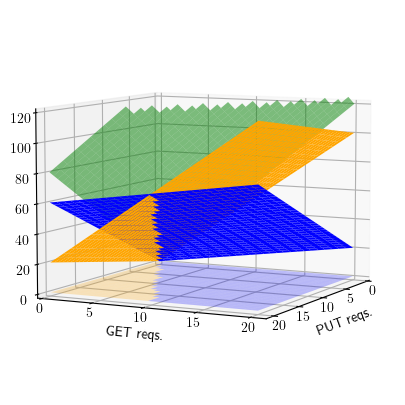

In [12]:
## Thank you ChatGPT for helping write this code!
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from adjustText import adjust_text

plt.rcParams['text.usetex'] = True

#%matplotlib widget

# Generate 3D space
xmin = 20
ymin = 20
X, Y = np.meshgrid(np.linspace(0, xmin, 30), np.linspace(0, ymin, 30))
xlen = len(X)
ylen = len(Y)

# Example workloads
#w0=np.array([3,8])
#w1=np.array([6,2])
#w2=np.array([9,10])
#W=[w0,w1,w2]
W=[np.array([10,10])]

p0 = [3, 1]
p1 = [1, 5]
p2 = [p0[0] + p1[0], p0[1] + p1[1]]
P=[p0, p1, p2]

wlColors = ['red', 'black', 'c']
#z_limit = 2500
#z_limit = 500
z_limit = 120
alpha = 1
alpha_irrelevant = 0.5
tickpadding = -5
labelpadding = -5
titleSpacing = dict(pad=-14, y=0.92)

def gen_fig1(ax, plot_expensive = False, plot_lowest_workload_markers = True, plot_workload_line = True, title = None, plot_drift_illustration = False, latency_labels = False, Planes=[0,1,2]):
    facecolors = np.empty((xlen, ylen), dtype=object)

    Z1 = p0[0] * X + p0[1] * Y
    Z2 = p1[0] * X + p1[1] * Y
    Z3 = p2[0] * X + p2[1] * Y

    if 0 in Planes and 1 in Planes:
        Z_lower = np.minimum(Z1, Z2)
    elif 0 in Planes:
        Z_lower = Z1
    elif 1 in Planes:
        Z_lower = Z2
    Z_lower = np.minimum(Z_lower, Z3)  # Compute the lower of the two planes

    alpha_bottom = 1
    # Plot the z=0 plane with colors corresponding to the lowest plan
    for y in range(ylen):
        for x in range(xlen):
            if Z_lower[x, y] == Z1[x, y]:
                facecolors[x, y] = colors.to_rgba('blue', alpha_bottom)
            elif Z_lower[x, y] == Z2[x, y]:
                facecolors[x, y] = colors.to_rgba('orange', alpha_bottom)
            elif Z_lower[x, y] == Z3[x, y]:
                facecolors[x, y] = colors.to_rgba('green', alpha_bottom)
    ax.plot_surface(X, Y, np.full_like(X,0), facecolors=facecolors, edgecolor=None, shade=False, alpha=0.25, zorder=2)

    # Plot the 3D planes
    def clip_color(*, xlen, ylen, Z, limit, color, lowest, alpha_bottom=1, alpha_top=1):
        return np.array([[colors.to_rgba(color, alpha_bottom if lowest[x,y] == Z[x,y] else alpha_top if Z[x,y] < limit else 0) for y in range(ylen)] for x in range(xlen)], dtype=object)

    # Make Z1 invisible where greater than limit
    facecolorsZ1bottom = clip_color(xlen=xlen, ylen=ylen, Z=Z1, limit=z_limit, alpha_bottom=alpha, alpha_top=0, color="blue", lowest=Z_lower)
    facecolorsZ1top = clip_color(xlen=xlen, ylen=ylen, Z=Z1, limit=z_limit, alpha_bottom=0, alpha_top=alpha, color="blue", lowest=Z_lower)
    facecolorsZ2bottom = clip_color(xlen=xlen, ylen=ylen, Z=Z2, limit=z_limit, alpha_bottom=alpha, alpha_top=0, color="orange", lowest=Z_lower)
    facecolorsZ2top = clip_color(xlen=xlen, ylen=ylen, Z=Z2, limit=z_limit, alpha_bottom=0, alpha_top=alpha, color="orange", lowest=Z_lower)
    facecolorsZ3 = clip_color(xlen=xlen, ylen=ylen, Z=Z3, limit=z_limit, alpha_bottom=alpha_irrelevant, alpha_top=alpha_irrelevant, color="green", lowest=Z_lower)

    lw=0.2
    edgecolor='gray'
    edgecolor=None
    if plot_expensive:
        ax.plot_surface(X, Y, Z3, facecolors=facecolorsZ3, edgecolor=edgecolor, lw=lw, shade=False, zorder=2, label="$p''=\{o,o'\}$")
    if 0 in Planes:
        ax.plot_surface(X, Y, Z1, facecolors=facecolorsZ1top, edgecolor=edgecolor, lw=lw, shade=False, zorder=4)
    if 1 in Planes:
        ax.plot_surface(X, Y, Z2, facecolors=facecolorsZ2top, edgecolor=edgecolor, lw=lw, shade=False, zorder=4)
    if 0 in Planes:
        ax.plot_surface(X, Y, Z1, facecolors=facecolorsZ1bottom, edgecolor=edgecolor, lw=lw, shade=False, zorder=7, label="$p=\{o\}$")
    if 1 in Planes:
        ax.plot_surface(X, Y, Z2, facecolors=facecolorsZ2bottom, edgecolor=edgecolor, lw=lw, shade=False, zorder=6, label="$p'=\{o'\}$")

    lw=1.5
    # Plot points of workload w0
    for i, w in enumerate(W):
        a = [ (w[0], w[1], w@p) for p in [p0,p1,p2]]
        a = [(x, y, min(z for a, b, z in a if a == x and b == y)) for x, y, z in a]
        
        if plot_lowest_workload_markers:
            # Draw markers at costs of workloads
            ax.scatter(*zip(*a), marker='x', color='r', lw=1.5, zorder=7)

        # Draw vertical lines at coordinates of workloads
        if plot_workload_line:
            x,y,z = a[0]
            ax.plot([x, x], [y, y], [-2, z*0.2], marker='^', markevery=[1], color=wlColors[i], ls='-', lw=1.5, zorder=8)
            ax.plot([x, x], [y, y], [z*0.2,z], marker='', color=wlColors[i], ls='dotted', lw=1.5, zorder=8)
            #ax.plot([x, x], [y, y], [z, z_limit], marker='', color=wlColors[i], ls='dotted', lw=1.5, zorder=5)
            #ax.plot([w[0], w[0]], [w[1], w[1]], [-2, z_limit], marker='', color=wlColors[i], ls='--', lw=1.5, zorder=6)

        if plot_drift_illustration:
            # Direction of workload drift
            drift = w.copy()
            drift[0] *= 1.15
            drift[1] *= 0.95
            z_drift = min([drift@p for p in [p0,p1,p2]])
            z = min([w@p for p in [p0,p1,p2]])

            intersection = np.array([14,7])
            #intersection = np.array([10,5])
            z_intersect = min([intersection@p for p in [p0,p1,p2]])

            ax.scatter([intersection[0], intersection[0]], [intersection[1],intersection[1]], [-2, z_intersect], marker='x', color='r', lw=1.5, zorder=7)

            #ax.plot([intersection[0], intersection[0]], [intersection[1], intersection[1]], [-2, z_intersect], marker='x', markevery=[1], color=wlColors[i], ls='dotted', lw=1.5, zorder=8)
            ax.plot([w[0], intersection[0]], [w[1], intersection[1]], [z, z_intersect], marker='', markevery=[1], color=wlColors[i], ls='dotted', lw=1.5, zorder=8)

            ax.plot([w[0], drift[0]], [w[1], drift[1]], [-2, -2], marker='<', markevery=[1], color=wlColors[i], ls='-', lw=1.5, zorder=8)
            #ax.plot([w[0], drift[0]], [w[1], drift[1]], [z, z_drift], marker='<', markevery=[1], color=wlColors[i], ls='--', lw=1.5, zorder=8)
            #ax.plot([w[0], drift[0]], [w[1], drift[1]], [z, z_drift], marker='<', markevery=[1], color=wlColors[i], ls='--', lw=1.5, zorder=8)

    if title is not None:
        ax.set_title(title, **titleSpacing)

    ax.set_xticks(range(0, xmin+1, 5))
    ax.set_yticks(range(0, ymin+1, 5))

    # Set tick padding but keep labels as they are
    ax.tick_params(axis='x', which='major', pad=tickpadding)
    ax.tick_params(axis='y', which='major', pad=tickpadding)
    ax.tick_params(axis='z', which='major', pad=tickpadding+3)
    #ax.grid()

    # Set axis labels
    if latency_labels:
        ax.set_xlabel(r'Write frequency ($\vec{w_i}$)', labelpad=labelpadding)
        ax.set_ylabel(r'Read frequency ($\vec{r_i}$)', labelpad=labelpadding)
        ax.set_zlabel(r'Latency', labelpad=labelpadding+3)
    else:
        ax.set_xlabel(r'PUT reqs.', labelpad=labelpadding)
        ax.set_ylabel(r'GET reqs.', labelpad=labelpadding)
        ax.set_zlabel(r'Cost (\textcent)', labelpad=labelpadding+3)

    # Set z-axis limits
    ax.set_zlim(bottom=0, top=z_limit)
    ax.set_ylim(0)
    ax.set_xlim(0)

    return ax

figsize=(5.5, 5)
view = dict(elev=19, azim=19, roll=0)
view = dict(elev=7, azim=27, roll=0)
sav_pad = 0.4

fig2 = plt.figure(figsize=figsize)
ax2 = fig2.add_subplot(111, projection='3d')
ax2.computed_zorder=False
ax2 = gen_fig1(ax2, plot_expensive=True, plot_workload_line=False, plot_lowest_workload_markers=False, Planes=[0,1,2])
ax2.view_init(**view)
fig2.savefig('intuition_green+blue+orange_plane.pdf',bbox_inches='tight', pad_inches=sav_pad)
fig2.savefig('intuition_green+blue+orange_plane.png',bbox_inches='tight', pad_inches=sav_pad)

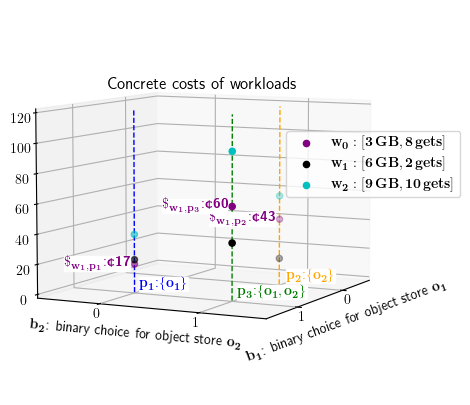

In [3]:

fig5 = plt.figure(figsize=figsize)
ax5 = fig5.add_subplot(111, projection='3d')
ax5.computed_zorder=False
ax5 = gen_fig2(ax5, workloads=[0,1,2], workloads_with_labels=[0])
ax5.view_init(**view)
fig5.savefig(f'intuition-current-approach.pdf')


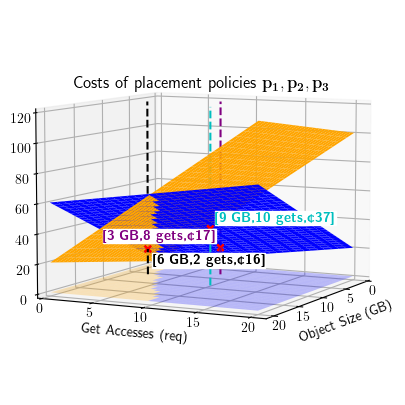

In [4]:
# Create 3D plot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder=False
ax  = gen_fig1(ax, title=r"Costs of placement policies $\mathbf{p_1,p_2,p_3}$", plot_expensive=False, plot_workload_line=True)
ax.view_init(**view)
fig.savefig('intuition-min.pdf',bbox_inches='tight', pad_inches=sav_pad)


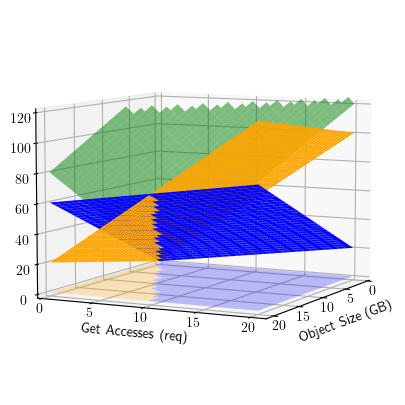

In [5]:

fig4 = plt.figure(figsize=figsize)
ax4 = fig4.add_subplot(111, projection='3d')
ax4.computed_zorder=False
ax4 = gen_fig1(ax4, plot_expensive=True, plot_workload_line=False, plot_lowest_workload_markers=False)
ax4.view_init(**view)
fig4.savefig('intuition-enumeration.pdf',bbox_inches='tight', pad_inches=sav_pad)


In [ ]:

for w in [[0],[1],[2]]:
    fig3 = plt.figure(figsize=figsize)
    ax3 = fig3.add_subplot(111, projection='3d')
    ax3.computed_zorder=False
    ax3 = gen_fig2(ax3, workloads=w)
    ax3.view_init(**view)
    fig3.savefig(f'intuition-current-approach_{"-".join([f"w_{i}" for i in w])}.pdf')

# Show the plot
plt.show()
